In [1]:
## CNN - with Batch Normalization - Example 07

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model

### Load the data

In [9]:
cifar10 = tf.keras.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()


#### Normalize

In [4]:
x_train, x_test = x_train / 255.0, x_test / 255.0

#### Flatten

In [14]:
y_test.shape

(10000, 1)

In [15]:
y_test[0][0]

3

In [16]:
y_train, y_test = y_train.flatten(), y_test.flatten()


In [17]:
y_test[0]

3

#### Shape of data

In [6]:
print("x_train.shape:", x_train.shape)
print("y_train.shape", y_train.shape)

x_train.shape: (50000, 32, 32, 3)
y_train.shape (50000,)


#### No of classes

In [3]:
# number of classes
K = len(set(y_train))
print("number of classes:", K)

number of classes: 10


### Batch Normalization

#### Why does Batch Normalization work for over fitting?

What is the benefit of batch normalizaton?
Typically normalization is done at the input layer when data is fed, later layers can't be normalized. So batch normalization provides a way to normalize the data before the hidden 
layer. It works because it introduces the NOISE at every layer which reduces the overfitting.
Noise adds the assumption for something new might come instead of overfit the data.

#### Model # 1

In [4]:
# Build the model using the functional API
i = Input(shape=x_train[0].shape)
# x = Conv2D(32, (3, 3), strides=2, activation='relu')(i)
# x = Conv2D(64, (3, 3), strides=2, activation='relu')(x)
# x = Conv2D(128, (3, 3), strides=2, activation='relu')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.2)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.2)(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.2)(x)

# x = GlobalMaxPooling2D()(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(K, activation='softmax')(x)

model = Model(i, x)

In [5]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

##### Summary

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496 

In [7]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50)

Epoch 1/50
1563/1563 [==============================] - 17s 6ms/step - loss: 1.7086 - accuracy: 0.4532 - val_loss: 0.9832 - val_accuracy: 0.6582
Epoch 2/50
1563/1563 [==============================] - 9s 6ms/step - loss: 0.8822 - accuracy: 0.6951 - val_loss: 0.7823 - val_accuracy: 0.7337
Epoch 3/50
1563/1563 [==============================] - 9s 6ms/step - loss: 0.6889 - accuracy: 0.7618 - val_loss: 0.7146 - val_accuracy: 0.7542
Epoch 4/50
1563/1563 [==============================] - 9s 6ms/step - loss: 0.5700 - accuracy: 0.8021 - val_loss: 0.6747 - val_accuracy: 0.7738
Epoch 5/50
1563/1563 [==============================] - 9s 6ms/step - loss: 0.4835 - accuracy: 0.8298 - val_loss: 0.7549 - val_accuracy: 0.7535
Epoch 6/50
1563/1563 [==============================] - 9s 6ms/step - loss: 0.4069 - accuracy: 0.8586 - val_loss: 0.6300 - val_accuracy: 0.7861
Epoch 7/50
1563/1563 [==============================] - 9s 6ms/step - loss: 0.3356 - accuracy: 0.8820 - val_loss: 0.6302 - val_accuracy

##### Fit with data augmentation

In [8]:
# Fit with data augmentation
# Note: if you run this AFTER calling the previous model.fit(), it will CONTINUE training where it left off
batch_size = 32
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(x_train, y_train, batch_size)
steps_per_epoch = x_train.shape[0] // batch_size
print(steps_per_epoch)


1562


In [9]:
history = model.fit(train_generator, validation_data=(x_test, y_test), steps_per_epoch=steps_per_epoch, epochs=50)

Epoch 1/50
1562/1562 [==============================] - 27s 17ms/step - loss: 0.5637 - accuracy: 0.8198 - val_loss: 0.5155 - val_accuracy: 0.8364
Epoch 2/50
1562/1562 [==============================] - 26s 17ms/step - loss: 0.4424 - accuracy: 0.8548 - val_loss: 0.4903 - val_accuracy: 0.8450
Epoch 3/50
1562/1562 [==============================] - 26s 17ms/step - loss: 0.4146 - accuracy: 0.8630 - val_loss: 0.4754 - val_accuracy: 0.8480
Epoch 4/50
1562/1562 [==============================] - 26s 16ms/step - loss: 0.3961 - accuracy: 0.8680 - val_loss: 0.4442 - val_accuracy: 0.8531
Epoch 5/50
1562/1562 [==============================] - 26s 17ms/step - loss: 0.3778 - accuracy: 0.8742 - val_loss: 0.4632 - val_accuracy: 0.8542
Epoch 6/50
1562/1562 [==============================] - 26s 17ms/step - loss: 0.3611 - accuracy: 0.8785 - val_loss: 0.4484 - val_accuracy: 0.8553
Epoch 7/50
1562/1562 [==============================] - 26s 17ms/step - loss: 0.3514 - accuracy: 0.8823 - val_loss: 0.4490 -

In [14]:
from tensorflow.keras.models import load_model
model.save('03_cifar_with_batch_norm.h5')

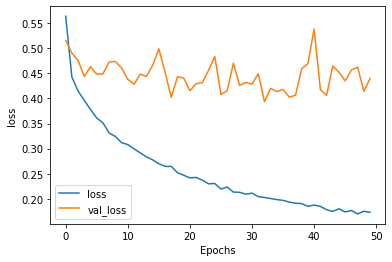

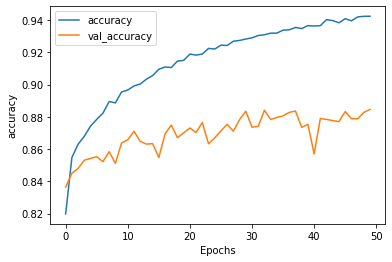

In [10]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "loss")
plot_graphs(history, "accuracy")

##### Model Evaluation

##### Predictions

In [ ]:
y_prediction = model.predict(x_test).argmax(axis=1)

##### Reports

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1000
           1       0.94      0.96      0.95      1000
           2       0.88      0.81      0.84      1000
           3       0.78      0.76      0.77      1000
           4       0.86      0.88      0.87      1000
           5       0.88      0.79      0.83      1000
           6       0.82      0.96      0.88      1000
           7       0.93      0.91      0.92      1000
           8       0.95      0.94      0.94      1000
           9       0.91      0.94      0.92      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000

[[902   6  24   7   9   1   9   4  21  17]
 [  1 956   0   0   1   0   3   0   5  34]
 [ 28   2 810  28  36  17  57   8   4  10]
 [ 16   4  26 763  30  62  68  17   6   8]
 [  7   1  19  26 877  10  35  23   1   1]
 [  6   1  19 105  34 791 

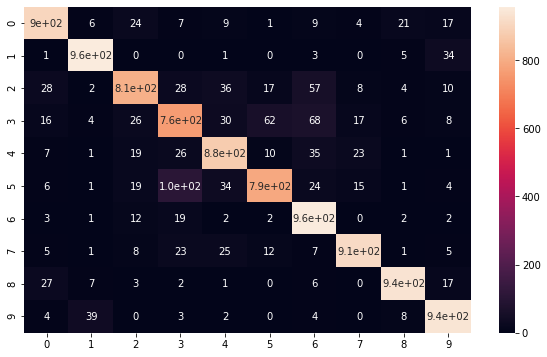

In [11]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(y_test,y_prediction))
print(confusion_matrix(y_test,y_prediction))

import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(y_test,y_prediction),annot=True)

In [12]:
# label mapping
labels = '''airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck'''.split()

##### Predictions go wrong!

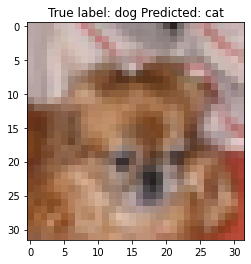

In [13]:
# Show some misclassified examples
misclassified_idx = np.where(y_prediction != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i], cmap='gray')
plt.title("True label: %s Predicted: %s" % (labels[y_test[i]], labels[y_prediction[i]]));

#### Conclusion : Final thoughts